In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
(x_train,y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train[...,tf.newaxis],y_train[:,tf.newaxis]))

In [4]:
def preprocess(img,label):
    img = tf.cast(img,tf.float32)
    img = img/127.5 -1
    return img,label

In [5]:
train_ds = train_ds.map(preprocess)

In [6]:
train_ds = train_ds.batch(64).shuffle(1000)

In [7]:
class generator(tf.keras.Model):
    def __init__(self):
        super(generator,self).__init__()
        self.dense_z = tf.keras.layers.Dense(1024,input_dim=(100,))
        self.dense_z2 = tf.keras.layers.Dense(128*7*7)
        self.bnz1 = tf.keras.layers.BatchNormalization()
        self.reshapez = tf.keras.layers.Reshape((7,7,128))
        
        self.embed = tf.keras.layers.Embedding(10,100)
        self.flatten = tf.keras.layers.Flatten()
        self.dense_y = tf.keras.layers.Dense(1024)
        self.dense_y2 = tf.keras.layers.Dense(128*7*7)
        self.bny1 = tf.keras.layers.BatchNormalization()
        self.reshapey = tf.keras.layers.Reshape((7,7,128))
        
        self.concate = tf.keras.layers.Concatenate()
        
        self.upsampling1 = tf.keras.layers.UpSampling2D(size=2)
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=5,padding='same')
        
        self.upsampling2 = tf.keras.layers.UpSampling2D(size=2)
        self.conv2 = tf.keras.layers.Conv2D(1,kernel_size=5,padding='same')
                
    def call(self, input_tensor, labels,training=False):
        
        z = self.dense_z(input_tensor)
        z = tf.nn.tanh(z)
        z = self.dense_z2(z)
        z = self.bnz1(z, training=training)
        z = self.reshapez(z)
        
        y = self.embed(labels)
        y = self.dense_y(y)
        y = tf.nn.tanh(y)
        y = self.dense_y2(y)
        y = self.bny1(y, training=training)
        y = self.reshapey(y)
        
        x = self.concate([z,y])
        x = self.upsampling1(x)
        x = self.conv1(x)
        x = tf.nn.tanh(x)
        
        x = self.upsampling2(x)
        x = self.conv2(x)
        x = tf.nn.tanh(x)
        return x

In [8]:
class discriminator(tf.keras.Model):
    def __init__(self):
        super(discriminator,self).__init__()

        self.conv1=tf.keras.layers.Conv2D(64, kernel_size=5,padding='same')
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=2)
        self.conv2 = tf.keras.layers.Conv2D(128,kernel_size=5)
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=2)
        
        self.embed = tf.keras.layers.Embedding(10,100)
        self.flatten = tf.keras.layers.Flatten()
        self.dense_y = tf.keras.layers.Dense(1024)
        self.dense_y2 = tf.keras.layers.Dense(128*5*5)
        self.bny1 = tf.keras.layers.BatchNormalization()
        self.reshapey = tf.keras.layers.Reshape((5,5,128))
        
        self.concate = tf.keras.layers.Concatenate()
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024)
        self.dense2 = tf.keras.layers.Dense(1)
                
    def call(self,input_tensor,labels, training=False):
        
        x = self.conv1(input_tensor)
        x = tf.nn.tanh(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = tf.nn.tanh(x)
        x = self.maxpool2(x)
        
        y = self.embed(labels)
        y = self.flatten(y)
        y = self.dense_y(y)
        y = tf.nn.tanh(y)
        y = self.dense_y2(y)
        y = self.bny1(y, training = training)
        y = self.reshapey(y)
        
        x = self.concate([x,y])
        x = self.flat(x)
        x = self.dense1(x)
        x = tf.nn.tanh(x)
        x = self.dense2(x)
        x = tf.nn.sigmoid(x)
        
        return x

In [9]:
g = generator()
d = discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)


In [10]:
def cross_entropy(x,y):
    return tf.losses.BinaryCrossentropy(from_logits=True)(x,y)
    

def generator_loss(fake_output):
    fake_label = tf.ones_like(fake_output)
    return cross_entropy(fake_label,fake_output)

def discriminator_loss(real_output,fake_output):
    fake_loss = cross_entropy(tf.ones_like(real_output),real_output)
    real_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    return fake_loss*0.5 + real_loss*0.5



In [11]:
def sample(g):
    fig, axis =plt.subplots(2,5)
    
    for i in range(2):
        for j in range(5):
            noise = np.random.normal(0,1,(1,100))
            gen_img = g(noise,np.array(i*5+j).reshape((-1,1)))
            axis[i,j].imshow(gen_img[0]*127.5+127.5)
            axis[i,j].axis('off')
    plt.show()

100%|██████████| 938/938 [00:17<00:00, 55.13it/s]


epoch : 1 gen_loss:0.550436794757843 disc_loss 0.6201245784759521


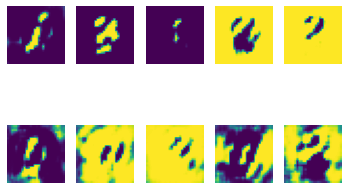

100%|██████████| 938/938 [00:16<00:00, 56.38it/s]


epoch : 2 gen_loss:0.540904700756073 disc_loss 0.6272440552711487


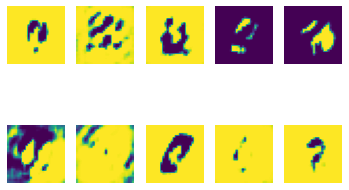

100%|██████████| 938/938 [00:17<00:00, 55.05it/s]


epoch : 3 gen_loss:0.5413195490837097 disc_loss 0.6287669539451599


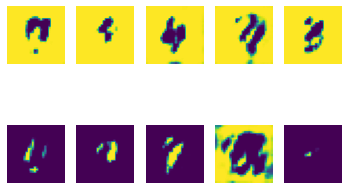

100%|██████████| 938/938 [00:16<00:00, 56.53it/s]


epoch : 4 gen_loss:0.553411602973938 disc_loss 0.6265133023262024


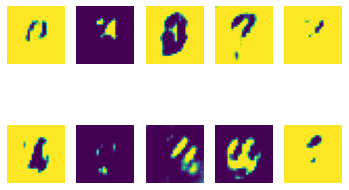

100%|██████████| 938/938 [00:16<00:00, 55.98it/s]


epoch : 5 gen_loss:0.5787250995635986 disc_loss 0.6260589957237244


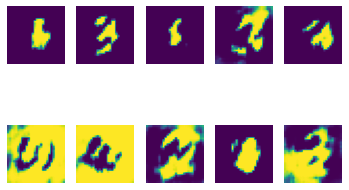

100%|██████████| 938/938 [00:16<00:00, 56.16it/s]


epoch : 6 gen_loss:0.5587182641029358 disc_loss 0.6221278309822083


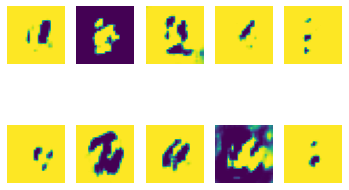

100%|██████████| 938/938 [00:16<00:00, 56.40it/s]


epoch : 7 gen_loss:0.5695793032646179 disc_loss 0.624030351638794


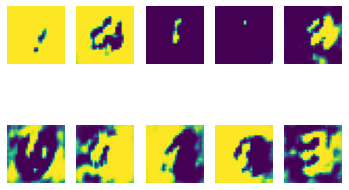

100%|██████████| 938/938 [00:16<00:00, 55.59it/s]


epoch : 8 gen_loss:0.555529773235321 disc_loss 0.6260601878166199


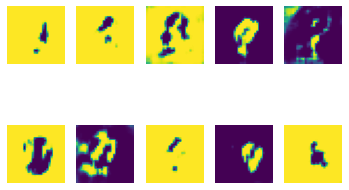

100%|██████████| 938/938 [00:16<00:00, 55.28it/s]


epoch : 9 gen_loss:0.5665978789329529 disc_loss 0.6302801966667175


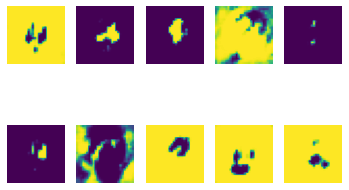

100%|██████████| 938/938 [00:16<00:00, 55.40it/s]


epoch : 10 gen_loss:0.5679525136947632 disc_loss 0.6308194398880005


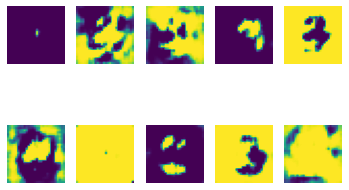

100%|██████████| 938/938 [00:16<00:00, 55.90it/s]


epoch : 11 gen_loss:0.546022891998291 disc_loss 0.6296593546867371


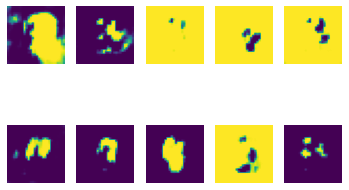

100%|██████████| 938/938 [00:17<00:00, 54.47it/s]


epoch : 12 gen_loss:0.5393779277801514 disc_loss 0.6307519674301147


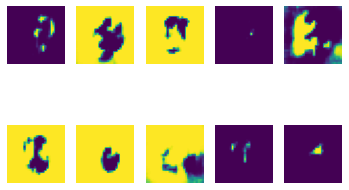

100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


epoch : 13 gen_loss:0.5331764221191406 disc_loss 0.6340466737747192


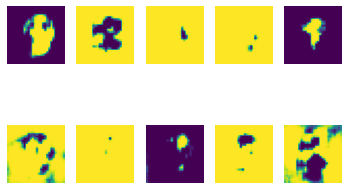

100%|██████████| 938/938 [00:16<00:00, 65.93it/s]


epoch : 14 gen_loss:0.5303642749786377 disc_loss 0.6355512142181396


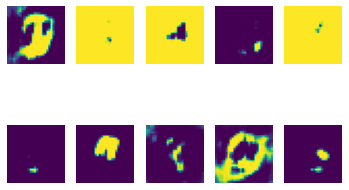

100%|██████████| 938/938 [00:16<00:00, 56.42it/s]


epoch : 15 gen_loss:0.5369428992271423 disc_loss 0.6312353014945984


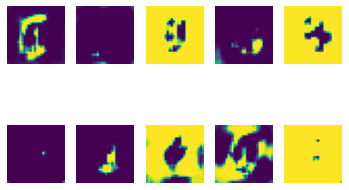

100%|██████████| 938/938 [00:16<00:00, 56.68it/s]


epoch : 16 gen_loss:0.5493277907371521 disc_loss 0.6275249123573303


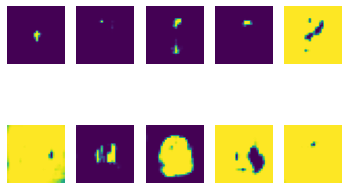

100%|██████████| 938/938 [00:16<00:00, 56.00it/s]


epoch : 17 gen_loss:0.5534480810165405 disc_loss 0.627885103225708


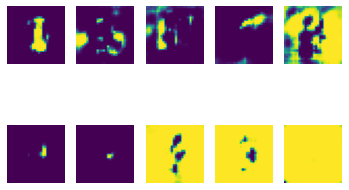

100%|██████████| 938/938 [00:16<00:00, 56.71it/s]


epoch : 18 gen_loss:0.5404840111732483 disc_loss 0.629473090171814


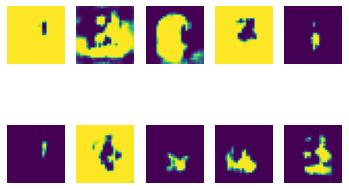

100%|██████████| 938/938 [00:16<00:00, 55.32it/s]


epoch : 19 gen_loss:0.545749306678772 disc_loss 0.6288663148880005


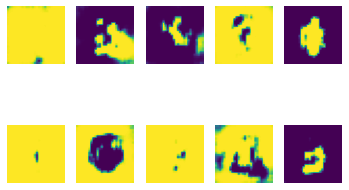

100%|██████████| 938/938 [00:16<00:00, 55.78it/s]


epoch : 20 gen_loss:0.5538644790649414 disc_loss 0.6285892724990845


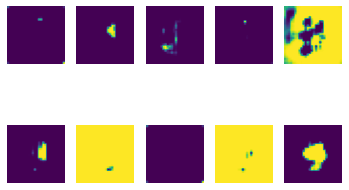

100%|██████████| 938/938 [00:16<00:00, 69.60it/s]


epoch : 21 gen_loss:0.5659624934196472 disc_loss 0.640052855014801


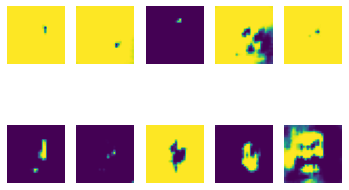

100%|██████████| 938/938 [00:16<00:00, 55.54it/s]


epoch : 22 gen_loss:0.5676277279853821 disc_loss 0.6338024139404297


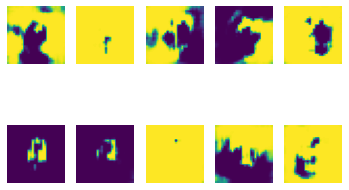

100%|██████████| 938/938 [00:16<00:00, 56.99it/s]


epoch : 23 gen_loss:0.5517846345901489 disc_loss 0.6244505643844604


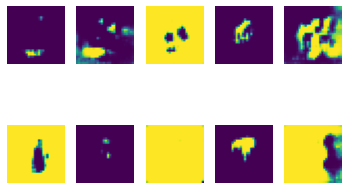

100%|██████████| 938/938 [00:16<00:00, 56.77it/s]


epoch : 24 gen_loss:0.5372258424758911 disc_loss 0.6297883987426758


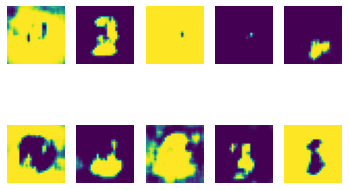

100%|██████████| 938/938 [00:16<00:00, 56.38it/s]


epoch : 25 gen_loss:0.534424364566803 disc_loss 0.6319625377655029


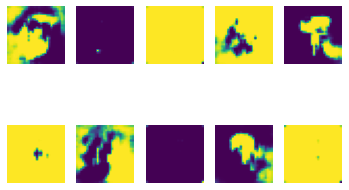

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
EPOCHS = 100

for epoch in range(1,EPOCHS+1):
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    for image_batch,label_batch in tqdm(train_ds):
        noise = np.random.normal(0,1,(len(label_batch),100))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:           
            real_output = d(image_batch,label_batch,training=True)
            generated_img = g(noise,label_batch, training=True)
            fake_output = d(generated_img,label_batch, training=True)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output,fake_output)
            
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
    gen_gradient = gen_tape.gradient(gen_loss,g.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss,d.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradient, g.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradient, d.trainable_variables))
    print(f'epoch : {epoch} gen_loss:{total_gen_loss/len(train_ds)} disc_loss {total_disc_loss/len(train_ds)}')
    sample(g)